# Qubit-data for Lithium Hydride

In [1]:
import pickle
from pylab import *
import numpy as np
import math as m
from functools import reduce
import matplotlib.pyplot as plt

## Preliminaries

The fermionic Hamiltonian in second quantization (with $M$ orbitals)

$$ H = \sum_{\alpha,\beta=1}^M t_{\alpha\beta}c^\dagger_\alpha c_\beta 
+ \frac{1}{2}\sum_{\alpha\beta=1}^M\sum_{\gamma\delta=1}^M u_{\alpha\beta\gamma\delta}c^\dagger_\alpha c^\dagger_\gamma c_\delta c_\beta$$

is mapped into a qubit Hamiltonian in the form

$$ H = \sum_kc_kP_k $$

where $c_k$ are interaction coefficients and $P_k$ are elements of the $N$-qubit Pauli group $\mathcal{P}_N=\{\mathbb{1},X,Y,Z\}^{\otimes N}$.

The interaction coefficients and the Pauli operators can be found in the `interaction.file` and the `pauli.file` respectively.

Specifics:
- Number of qubits: 4
- Molecule geometry: bond distance
- Fermionic basis: atomic STO-3G
- Qubit mapping: spin-parity

## Exact diagonalization

In [2]:
# Identity 
I = np.asarray([[1.,0.],[0.,1.]])
# Pauli X
X = np.asarray([[0.,1.],[1.,0.]])
# Pauli Y
Y = np.asarray([[0.,-1j],[1j,0.]])
# Pauli Z
Z = np.asarray([[1.,0.],[0.,-1.]])

In [3]:
def operatorfromstring(pauli_string):
    """
    Generate a many-body operator from a list of single-qubit 
    pauli matrices.
    ---------------------------------------------------------
    Input    pauli_string: str , (ex: [X,Z,X,Y,...])
    
    Output   pauli_op: np.array, shape = [2**N,2**N]
    """
    op_list = []
    for k in range(len(pauli_string)):
        if (pauli_string[k] == 'X'):
            op_list.append(X)
        elif (pauli_string[k] == 'Y'):
            op_list.append(Y)
        elif (pauli_string[k] == 'Z'):
            op_list.append(Z)
        else:
            op_list.append(I)

    return reduce(np.kron,op_list)

def hamiltonian(pauli_list,interactions):
    """
    Generate a many-body hamiltonian
    ---------------------------------------------------------
    Input    pauli_list: list of pauli strings
             interactions: list of interaction strengths
    
    Output   hamiltonian: np.array, shape = [2**N,2**N]
    """
    N = len(pauli_list[0])
    hamiltonian = np.zeros((1<<N,1<<N),dtype=complex)
    for i,pauli in enumerate(pauli_list):
        hamiltonian += interactions[i]*operatorfromstring(pauli)
    return hamiltonian

def eigensolve(hamiltonian):
    """
    Compute ground state energy and wavefunction
    """
    (eigenvalues,eigenstates) = np.linalg.eigh(hamiltonian)
    return eigenvalues[0],eigenstates[:,0]

In [4]:
pauli_list   = np.load('paulis.file',allow_pickle=True)
interactions = np.load('interactions.file',allow_pickle = True)
for k in range(10):
    print('Pauli:',pauli_list[k],' | Interaction: %.3E' % interactions[k])
print('...')

Pauli: IIII  | Interaction: -8.022E+00
Pauli: ZIII  | Interaction: -9.276E-02
Pauli: XZII  | Interaction: -2.941E-03
Pauli: XIII  | Interaction: 2.941E-03
Pauli: ZZII  | Interaction: -2.119E-01
Pauli: YYII  | Interaction: 7.428E-04
Pauli: XXII  | Interaction: -7.428E-04
Pauli: ZXII  | Interaction: 1.939E-02
Pauli: IXII  | Interaction: 1.939E-02
Pauli: IZII  | Interaction: 3.653E-01
...


In [5]:
# Build the full Hamiltonian and get the ground state energy / wavefunction
H = hamiltonian(pauli_list,interactions)
E0,psi0 = eigensolve(H)
print('Ground state energy: %.10f\n' % E0 )
print('Ground state wavefunction:\n\n',psi0)

Ground state energy: -8.9073963113

Ground state wavefunction:

 [-4.96394908e-03+0.j  2.53269627e-16+0.j -5.76276175e-02+0.j
  1.11651339e-01+0.j -3.26381702e-02+0.j  5.08356315e-16+0.j
  3.54539651e-02+0.j -5.76276175e-02+0.j  1.38777878e-16+0.j
  1.23592416e-25+0.j  5.01265465e-18+0.j -1.14084922e-17+0.j
 -9.88663405e-01+0.j -2.63778775e-17+0.j -3.26381702e-02+0.j
 -4.96394908e-03+0.j]


 ## Neural-network reconstruction

Quantum state reconstruction of the LiH ground state with a restricted Boltzmann machine, using the NetKet library.

References:
- _"Machine learning quantum states in the NISQ era"_ : review of quantum state reconstruction with restricted Boltzmann machines. https://arxiv.org/abs/1905.04312
- _"Precise measurement of quantum observables with neural-network estimators"_ RBM reconstruction of molecular ground states. https://arxiv.org/abs/1910.07596
- _"NetKet: A Machine Learning Toolkit for Many-Body Quantum Systems"_ Overview of the NetKet software library. https://arxiv.org/abs/1904.00031

In [6]:
from mpi4py import MPI 
import netket as nk

In [7]:
# Unitary matrices for the rotation in the X and Y bases
rotationX = 1./(math.sqrt(2))*np.asarray([[1.,1.],[1.,-1.]])
rotationY= 1./(math.sqrt(2))*np.asarray([[1.,-1j],[1.,1j]])

def LoadData(N,hilbert,path_to_samples, path_to_bases):
    training_samples = []
    training_bases = []

    tsamples = np.loadtxt(path_to_samples)
    assert(N == tsamples.shape[1])
    fin_bases = open(path_to_bases, 'r')
    lines = fin_bases.readlines()

    bases = []

    for b in lines:
        basis = ""
        assert(len(b) == N + 1)
        for j in range(N):
            basis += b[j]
        bases.append(basis)
    index_list = sorted(range(len(bases)), key=lambda k: bases[k])
    bases.sort()

    for i in range(len(tsamples)):
        training_samples.append(tsamples[index_list[i]].tolist())

    rotations = []

    tmp = ''
    b_index = -1
    for b in bases:
        if (b != tmp):
            tmp = b
            localop = nk.operator.LocalOperator(hilbert, 1.0)

            for j in range(N):
                if (tmp[j] == 'X'):
                    localop *= nk.operator.LocalOperator(hilbert, rotationX, [j])
                if (tmp[j] == 'Y'):
                    localop *= nk.operator.LocalOperator(hilbert, rotationY, [j])

            rotations.append(localop)
            b_index += 1
        training_bases.append(b_index)

    return tuple(rotations), np.asarray(training_samples), np.asarray(training_bases)

def OperatorFromString(op_string):                                                
    OpList = []                                                                   
    Sites = []                                                                    
    for k in range(len(op_string)):                                               
        if (op_string[k] == 'X'):                                                 
            OpList.append(X)                                                      
            Sites.append(k)                                                       
        elif (op_string[k] == 'Y'):                                               
            OpList.append(Y)                                                      
            Sites.append(k)                                                       
        elif (op_string[k] == 'Z'):                                               
            OpList.append(Z)                                                      
            Sites.append(k)                                                       
    return Sites,reduce(np.kron,OpList) 

def BuildHamiltonian(N,hilbert,pauli_path,interactions_path):                     
    pauli = np.load(pauli_path,allow_pickle=True)                                 
    interactions = np.load(interactions_path,allow_pickle=True)                   
                                                                                  
    hamiltonian = nk.operator.LocalOperator(hilbert, 0.0)                                                                                 
    for h in range(0,len(pauli)):                                                                                           
        flag = 0                                                                  
        for j in range(N):                                                        
            if (pauli[h][j]!='I'): flag = 1; break                                
        if flag == 0:                                                             
            hamiltonian += nk.operator.LocalOperator(hilbert,np.real(interactions[h]))
        else:                                                                     
            sites,operator = OperatorFromString(pauli[h])                         
            h_term = interactions[h]*operator
            hamiltonian += nk.operator.LocalOperator(hilbert,h_term,sites)        
            
    return hamiltonian 

In [8]:
N = 4          # Number of qubits
ns = 100000    # Number of training samples
lr = 0.01      # Learning rate
M = 10000      # Number of samples for the negative CD phase
bs = 1000      # Batch size
epochs = 500   # Epochs

samples_path = "train_samples.txt"
bases_path = "train_bases.txt"
pauli_path = "paulis.file"
interactions_path = "interactions.file"

In [9]:
# Lattice
graph = nk.graph.Hypercube(length=N, n_dim=1,pbc=False)
# Hilbert space
hilbert = nk.hilbert.Qubit(graph=graph)
# NetKet Hamiltonian
hamiltonian = BuildHamiltonian(N,hilbert,pauli_path,interactions_path)

In [10]:
# Load training data
rotations, tr_samples, tr_bases = LoadData(N,hilbert,samples_path, bases_path)
if (ns > tr_samples.shape[0]):
    "Not enough training samples"
else:
    training_samples = tr_samples[0:ns]
    training_bases   = tr_bases[0:ns]

In [64]:
# RBM wavefunction
ma = nk.machine.RbmSpinPhase(hilbert=hilbert, alpha=1)  # Real-weights RBM (amplitude + phase)
# ma = nk.machine.RbmSpin(hilbert=hilbert, alpha=1)        # Complex-weights RBM, alpha=num_hidden/N
ma.init_random_parameters(seed=1234, sigma=0.01)

In [65]:
# Sampler
sa = nk.sampler.MetropolisLocal(machine=ma)

# Optimizer + Stochastic Reconfiguration
#op = nk.optimizer.Sgd(learning_rate=lr)
op = nk.optimizer.RmsProp(learning_rate=lr,beta=0.9,epscut = 1.0e-6)
sr = nk.optimizer.SR(diag_shift=0.1)

In [66]:
# Quantum state tomography object
qst = nk.Qsr(
    sampler=sa,
    optimizer=op,
    samples=training_samples,
    rotations=rotations,
    bases=training_bases,
    n_samples=M,
    n_samples_data=bs,
    sr=sr,
    #sr=None
)
# Measure the energy while training
qst.add_observable(hamiltonian, "Energy")

/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Call to deprecated function 'add_observable'
  


In [67]:
# Training loop
import re
energy = []
radii = []
variance = []
test = []

for ep in qst.iter(epochs, 10):
    # Get energy measurement
    obs = qst.get_observable_stats()
    
    #===============
    splited = str(obs['Energy']).split(" ")
    energy.append(splited[1][2:])
    radii.append(splited[6][2:9])
    variance.append(splited[5][5:11])
    test.append(re.findall(r"[-+]?\d*\.\d+|\d+", str(obs['Energy'])))
#     print(splited)
    #==================
    
    # Compute fidelity with exact state
    psima = ma.to_array()
    overlap = np.abs(np.vdot(psima, psi0))
    
    fidelities_temp.append(overlap)
    
    print('Epoch = %d   ' % ep,end='')
    print('Overlap = %.6f   '% overlap,end='')
    print("observables={}".format(obs))

/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Call to deprecated function 'get_observable_stats'
  # Remove the CWD from sys.path while we load stuff.


Epoch = 0   Overlap = 0.259966   observables={'Energy': (-7.995 + 0.000i) ± 0.011 [var=0.448, R=1.00120], '': None}
Epoch = 10   Overlap = 0.338576   observables={'Energy': (-8.0431 + 0.0001i) ± 0.0066 [var=0.5091, R=0.99989], '': None}
Epoch = 20   Overlap = 0.387590   observables={'Energy': (-8.0689 + 0.0001i) ± 0.0050 [var=0.5510, R=0.99956], '': None}
Epoch = 30   Overlap = 0.440196   observables={'Energy': (-8.1082 - 0.0003i) ± 0.0067 [var=0.5431, R=0.99987], '': None}
Epoch = 40   Overlap = 0.489161   observables={'Energy': (-8.1603 - 0.0000i) ± 0.0086 [var=0.5200, R=1.00033], '': None}
Epoch = 50   Overlap = 0.535597   observables={'Energy': (-8.2165 + 0.0004i) ± 0.0081 [var=0.5003, R=1.00025], '': None}
Epoch = 60   Overlap = 0.598019   observables={'Energy': (-8.298 - 0.001i) ± 0.010 [var=0.448, R=1.00107], '': None}
Epoch = 70   Overlap = 0.659373   observables={'Energy': (-8.384 + 0.001i) ± 0.012 [var=0.407, R=1.00213], '': None}
Epoch = 80   Overlap = 0.714323   observables

In [58]:
print(test)

[['-8.9068', '0.0003', '0.0012', '0.0006', '1.01718'], ['-8.9071', '0.0001', '0.0012', '0.0007', '1.01478'], ['-8.9071', '0.0006', '0.0054', '0.0041', '1.05356'], ['-8.9065', '0.0003', '0.0014', '0.0010', '1.01377'], ['-8.9062', '0.0001', '0.0012', '0.0013', '1.00899'], ['-8.9032', '0.0001', '0.0030', '0.0031', '1.02176'], ['-8.9072', '0.0001', '0.0010', '0.0009', '1.00875'], ['-8.90850', '0.00023', '0.00095', '0.00095', '1.00675'], ['-8.9058', '0.0005', '0.0012', '0.0007', '1.01661'], ['-8.8987', '0.0025', '0.0040', '0.0065', '1.01850'], ['-8.9065', '0.0006', '0.0014', '0.0010', '1.01432'], ['-8.9062', '0.0011', '0.0030', '0.0022', '1.03163'], ['-8.9042', '0.0015', '0.0038', '0.0029', '1.03723'], ['-8.9059', '0.0001', '0.0016', '0.0013', '1.01509'], ['-8.9058', '0.0000', '0.0014', '0.0015', '1.00974'], ['-8.9052', '0.0017', '0.0026', '0.0015', '1.03427'], ['-8.90512', '0.00015', '0.00057', '0.00095', '1.00190'], ['-8.882', '0.000', '0.014', '0.014', '1.10079'], ['-8.90617', '0.00011',

x_val [1.0012, 0.99989, 0.99956, 0.99987, 1.00033, 1.00025, 1.00107, 1.00213, 1.00265, 1.00137, 1.00294, 1.00329, 1.00265, 1.0019, 1.00443, 1.00351, 1.00186, 1.00166, 1.00302, 1.00379, 1.00343, 1.00685, 1.01043, 1.00673, 1.05054, 1.00513, 1.00085, 1.01003, 1.04731, 1.01318, 1.03014, 1.04945, 1.06094, 1.01676, 1.06511, 1.04483, 1.01415, 1.07456, 1.10936, 1.00016, 1.10322, 1.04488, 1.59448, 1.00147, 2.71868, 1.18824, 0.99987, 6.88636, 7.00118, 1.0009]
y_val [-7.995, -8.0431, -8.0689, -8.1082, -8.1603, -8.2165, -8.298, -8.384, -8.454, -8.526, -8.606, -8.6933, -8.7258, -8.8055, -8.8128, -8.85, -8.8605, -8.8745, -8.8768, -8.8852, -8.8921, -8.888, -8.8885, -8.8968, -8.8922, -8.8939, -8.8964, -8.8962, -8.897, -8.8948, -8.8914, -8.8933, -8.8963, -8.8928, -8.8994, -8.9051, -8.9058, -8.9011, -8.895, -8.90645, -8.901, -8.9043, -8.874, -8.91028, -8.887, -8.883, -8.91228, -8.877, -8.806, -8.90512]


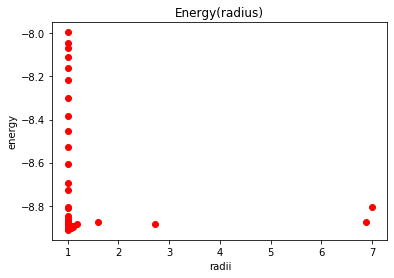

In [70]:
# plot 
x_val = []
y_val = []
var = []

for data in range(len(test)):
    y_val.append(float(test[data][0]))
    x_val.append(float(test[data][4]))
    var.append(float(test[data][3]))
    
print("x_val", x_val)
print("y_val", y_val)

plt.plot(x_val, y_val,'ro')
plt.xlabel('radii')
plt.ylabel('energy')
plt.title('Energy(radius)')
plt.show()

# plt.plot(x_val, y_val,'ro')
# plt.xlabel('radii')
# plt.ylabel('energy')
# plt.title('Energy(radius)')
# plt.show()